Wall time: 6.99 ms
Wall time: 15 ms
Wall time: 21 ms


C:\Program Files (x86)\Python36-32\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Wall time: 6 ms


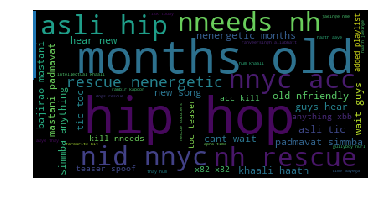

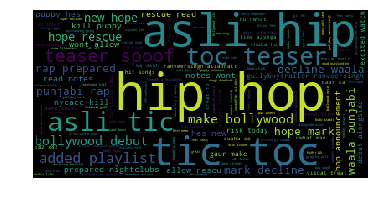

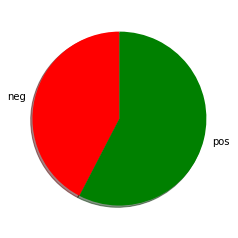

In [6]:
#importing necessary modules
import pandas as pd
tweets =pd.read_csv("gully.csv",header=0)
tweets.head()


tweets_text = pd.DataFrame(tweets)
# print (len(tweets_text))

#cleaning up tweets
import re

def CleanTweet(tweet):

    #Convert to lower case
    tweet = tweet.lower()
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #Convert www.* or https?://* to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','AT_USER',tweet)
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #trim
    tweet = tweet.strip('\'"').replace("|","")
    #replace non ascii characters
    re.sub(r'[^\\x00-\\xff]',r'', tweet) 
    tweet = tweet.replace("\\xe2","").replace("\\x80","").replace("\\x99","").replace("\\xf0","").replace("\\x9f","").replace("\\x98","").replace("\\xad","").replace("\\xa6","").replace("\\x9f","")
    return tweet

text = tweets_text['text'].values.tolist()
# len(text)
clean_tweets = []
for i in text:
    clean_tweets.append(CleanTweet(i))
    
    

#Process tweets for feature extraction
#tokenization and normalization
import string
from nltk.tokenize import TweetTokenizer 
from nltk.corpus import stopwords 
#tokenization
def process(tweet, tokenizer=TweetTokenizer(), stopwords=[]): 
  tokens = tokenizer.tokenize(tweet) 
  return [tok for tok in tokens if tok not in stopwords and not  
          tok.isdigit()]

tweet_tokenizer = TweetTokenizer() 
punct = list(string.punctuation) 
stopword_list = stopwords.words('english') + punct + ['rt', 'via', '...', 'AT_USER', 'URL', "'"]
#normalization         
def normalize_contractions(tokens, stopwords =[]): 
  token_map = { 
    "i'm": "i am", 
    "you're": "you are", 
    "it's": "it is", 
    "we're": "we are", 
    "we'll": "we will",
    "ain't": "are not",
    "ive" : "i have",
    "aint": "are not"
      } 
  for tok in tokens: 
    if tok in token_map.keys(): 
      for item in token_map[tok].split():
        if item not in stopwords:
         yield item
    else: 
      yield tok

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

def replaceTwoOrMore(s):
    #look for 2 or more repetitions of character and replace with the character itself
    pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
    return pattern.sub(r"\1\1", s)

def getFeatureVector(tweet):
        featureVector = []
        stopword_list = stopwords.words('english') + punct + ['rt', 'via', '...', 'AT_USER', 'URL', 'https', 'https',"'"]
        words = list(normalize_contractions(process(tweet, tokenizer=tweet_tokenizer, stopwords= stopword_list), stopwords= stopword_list))
        for w in words:
        #replace two or more with two occurrences
            w = replaceTwoOrMore(w)  
            #check if the word starts with an alphabet
            val = re.search(r"^[a-zA-Z][a-zA-Z0-9]*$", w)
            if val is None:
                continue
            else:    
                featureVector.append(w.lower())
        return featureVector

 #importting labelled data
import csv
import nltk
inpTweets = csv.reader(open('final.txt', 'r'), delimiter='\t', quotechar='|')
labeled_tweets = []
for row in inpTweets:
    sentiment = row[1]
    tweet = row[0]
    TrainedClean = CleanTweet(tweet)
    featureVector = getFeatureVector(TrainedClean)
    labeled_tweets.append((featureVector, sentiment))

#pulling only the words for vectorization
def words_in_tweets(labeled_tweets):
    all_words = []
    for (words, sentiment) in labeled_tweets:
        all_words.extend(words)
    return all_words

word_features = words_in_tweets(labeled_tweets)

#rejoining the words with sentimets for bag of words
def JoinWords(words):
    return( ' '.join(item for item in words))

labeled_data= pd.DataFrame((labeled_tweets), columns = ('Vectors', 'label'), copy = True)

labeled_data['Vectors']=labeled_data['Vectors'].apply(func = JoinWords)

X = labeled_data['Vectors']
y = labeled_data['label']

#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

#vectorization
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = 'word', preprocessor = None, tokenizer = None, stop_words = stopword_list, lowercase = False)

X_train_dtm = vectorizer.fit_transform(X_train)
vocab = vectorizer.get_feature_names()
# print (len(vocab))
# print (len(word_features))
# X_train_dtm
    
X_test_dtm = vectorizer.transform(X_test)

# import and initiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
# train the model using X_train_dtm (timing it with an IPython "magic command")
%time nb.fit(X_train_dtm, y_train)

# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

from sklearn import metrics
nba = metrics.accuracy_score(y_test, y_pred_class)


# import and initiate a logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)
#make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)
# calculate accuracy
# metrics.accuracy_score(y_test, y_pred_class)

from sklearn import metrics
lra = metrics.accuracy_score(y_test, y_pred_class)

#Initialize the classifier
from sklearn import svm
supportvec = svm.LinearSVC()
# train the model using X_train_dtm
%time supportvec.fit(X_train_dtm, y_train)
#make class predictions for X_test_dtm
y_pred_class = supportvec.predict(X_test_dtm)
# calculate accuracy
svma = metrics.accuracy_score(y_test, y_pred_class)

x=['nba','lra','svma']
y=[nba*100,lra*100,svma*100]

import matplotlib.pyplot as plt
plt.bar(x,y)
plt.savefig('MLModelComp.png', dpi=1200)


final_tweets = [CleanTweet(i) for i in clean_tweets]
#deduplication
final_tweets = [final_tweets[i] for i in range(len(final_tweets)) if i==0 or final_tweets[i] != final_tweets[i-1]]

#Process, clean and extract features to prepare for classifier 
processed_tweets = [] 
for item in final_tweets:
    featureVector = getFeatureVector(item)
    joined_strings = JoinWords(featureVector)
    processed_tweets.append(joined_strings)

collected_tweets = pd.DataFrame(processed_tweets)
collected_tweets.head()
final_collected_tweets = collected_tweets[0]

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer = 'word', preprocessor = None, tokenizer = None, stop_words = stopword_list,  binary = True, lowercase = False)

X_train_dtm = vectorizer.fit_transform(X_train)
X_test_dtm = vectorizer.transform(final_collected_tweets)

# import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()


# train the model using X_train_dtm (timing it with an IPython "magic command")
%time nb.fit(X_train_dtm, y_train)

# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

# sorting the classified data based on derived sentiments
classifiedData = [[final_tweets[x][1:],y_pred_class[x]] for x in range(len(final_tweets))]
filtered_sentenceall = [getFeatureVector(classifiedData[i][0]) for i in range(len(classifiedData))]

classifiedDatap = [[final_tweets[x][1:],y_pred_class[x]] for x in range(len(final_tweets)) if y_pred_class[x] == '1']
filtered_sentencep = [getFeatureVector(classifiedDatap[i][0]) for i in range(len(classifiedDatap))]

classifiedDatan = [[final_tweets[x][1:],y_pred_class[x]] for x in range(len(final_tweets)) if y_pred_class[x] == '0']
filtered_sentencen = [getFeatureVector(classifiedDatan[i][0]) for i in range(len(classifiedDatan))]

filtered_sentencepn=[]

for i in range(len(filtered_sentenceall)):
    for j in filtered_sentenceall[i]:
        filtered_sentencepn.append(j)
        
filtered_sentencepos=[]

for i in range(len(filtered_sentencep)):
    for j in filtered_sentencep[i]:
        filtered_sentencepos.append(j)

filtered_sentenceneg=[]

for i in range(len(filtered_sentencen)):
    for j in filtered_sentencen[i]:
        filtered_sentenceneg.append(j)

customfilters=['x8d','xa4','xef','xb8','xa5','x94','x9d','x8f','gully','boy','trailer','ranveer','singh','alia','bhatt','zoya','akthar','launch','official','video','url','liked','akhtar']

filtered_sentence2all = [i for i in  filtered_sentencepn if i not in customfilters]
filtered_sentence2pos = [i for i in  filtered_sentencepos if i not in customfilters]

# initiate wordcloud
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt1


wordcloud1 = WordCloud(background_color='black', max_words = 1000,  max_font_size = 60).generate(' '.join(filtered_sentence2all))
print(wordcloud1)
fig1 = plt1.figure(1)
plt1.imshow(wordcloud1)
plt1.axis('off')
plt1.show()
fig1.savefig("word1.png", dpi=1200)

wordcloud2 = WordCloud(background_color='black', max_words = 1000,  max_font_size = 60).generate(' '.join(filtered_sentence2pos))
print(wordcloud2)
fig2 = plt1.figure(1)
plt1.imshow(wordcloud2)
plt1.axis('off')
plt1.show()
fig2.savefig("word2.png", dpi=1200)

# wc(filtered_sentence2all,'black','AllML' )
# wc(filtered_sentence2pos,'black','posML' )

#extract counts for piechart
pos = len([i for i,j in classifiedData if j=='1'])
neg =  len([i for i,j in classifiedData if j=='0'])/2

labels = 'Negative',' Postive'
fig1, ax1 = plt.subplots()
ax1.pie([neg,pos], labels=['neg','pos'],colors=['r','g'],
        shadow=True, startangle=90)
plt.title=('Sentiment Analysis')
#plt.plot()
plt.savefig('pieML.png', dpi=900)
